# I. Import Libraries

In [174]:
import time
import joblib
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    brier_score_loss, classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve)
from sklearn.calibration import (calibration_curve, CalibratedClassifierCV)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (train_test_split, StratifiedKFold, cross_val_score)
from imblearn.over_sampling import SMOTE

# II. Load Data

In [175]:
data = pd.read_csv("diabetes_dataset.csv")

# III. Split Data (80/20)

In [176]:
# แยก Features (x) และ Target (y)
x = pd.get_dummies(data.drop("diabetes", axis=1), drop_first=True)
y = data["diabetes"]

In [177]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print("Dataset 100% :", data.shape)
print("x train Set 80% :", x_train.shape)
print("x test Set 20% :", x_test.shape)
print("y train Set 80% :", y_train.shape)
print("y Test Set 20% :", y_test.shape)

Dataset 100% : (100000, 9)
x train Set 80% : (80000, 13)
x test Set 20% : (20000, 13)
y train Set 80% : (80000,)
y Test Set 20% : (20000,)


In [178]:
def clip_outliers(df):
    df = df.copy()
    df["bmi"] = np.clip(df["bmi"], 10, 70)  # จำกัดช่วง BMI
    df["blood_glucose_level"] = np.clip(df["blood_glucose_level"], 50, 250)
    return df

x_train_clipped = clip_outliers(x_train)
x_test_clipped = clip_outliers(x_test)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_clipped)
x_test_scaled = scaler.transform(x_test_clipped)

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_scaled, y_train)

# IV. Training Model

In [179]:
model = CalibratedClassifierCV(estimator=LogisticRegression(max_iter=1000), method='isotonic', cv=5)
model.fit(x_train_resampled, y_train_resampled)
y_pred = model.predict(x_test_scaled)
y_prob = model.predict_proba(x_test_scaled)[:, 1]
threshold = 0.8607891879622116
y_pred = (y_prob >= threshold).astype(int)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, x_train_resampled, y_train_resampled, cv=cv, scoring="f1")
print("F1 scores from CV:", scores)
print("Mean F1:", scores.mean())

F1 scores from CV: [0.88935128 0.8894765  0.89089874 0.88583771 0.89094678]
Mean F1: 0.8893022017912491


In [180]:
# precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# # เลือก threshold ที่ให้ F1-score สูงสุด
# f1_scores = [f1_score(y_test, (y_prob >= t).astype(int)) for t in thresholds]
# best_threshold = thresholds[np.argmax(f1_scores)]

# print("Best Threshold:", best_threshold)

# # ใช้ threshold นี้ทำนาย
# y_pred_opt = (y_prob >= best_threshold).astype(int)
# print(classification_report(y_test, y_pred_opt))

In [181]:
# fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# roc_auc = auc(fpr, tpr)

# # plot ROC curve
# plt.figure(figsize=(8,6))
# plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

# # หา threshold ที่ดีที่สุด (Youden's J statistic)
# j_scores = tpr - fpr
# best_idx = j_scores.argmax()
# best_threshold = thresholds[best_idx]
# print(f'Best threshold: {best_threshold:.2f}')

# V. Model Result

## A) ROC-AUC Score, Accuracy, Precision, Recall, F1-score, Brier Score

In [182]:
roc_auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
brier = brier_score_loss(y_test, y_prob)

print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Accuracy     : {acc:.4f}")
print(f"Precision    : {prec:.4f}")
print(f"Recall       : {rec:.4f}")
print(f"F1-score     : {f1:.4f}")
print(f"Brier Score  : {brier:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

ROC-AUC Score: 0.9625
Accuracy     : 0.9575
Precision    : 0.7997
Recall       : 0.6671
F1-score     : 0.7274
Brier Score  : 0.0797

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     18300
           1       0.80      0.67      0.73      1700

    accuracy                           0.96     20000
   macro avg       0.88      0.83      0.85     20000
weighted avg       0.96      0.96      0.96     20000


Confusion Matrix:
 [[18016   284]
 [  566  1134]]


## B.) Calibration Curve

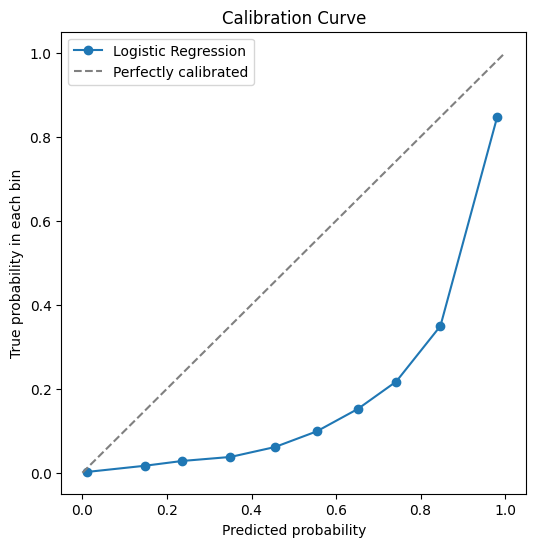

In [183]:
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", label="Logistic Regression")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("True probability in each bin")
plt.title("Calibration Curve")
plt.legend()
plt.show()

## C.) Inference Latency

In [184]:
start_time = time.time()
_ = model.predict(x_test)
latency = (time.time() - start_time) / len(X_test_scaled)  # Average Time 1 instance
print(f"Inference Latency: {latency*1000:.4f} ms per sample")

Inference Latency: 0.0029 ms per sample


c:\Users\Tutu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Tutu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Tutu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Tutu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Tutu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but Logi

## D.) Model Size

In [185]:
joblib.dump(model, "logreg_model.pkl")
model_size = os.path.getsize("logreg_model.pkl") / 1024  # KB
print(f"Model Size: {model_size:.2f} KB")

Model Size: 14.72 KB
